In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from mpl_toolkits import mplot3d

from numba import njit, float64, vectorize

from csr2d.wake import green_mesh
from csr2d.convolution import fftconvolve2

import time

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

In [3]:
# Chris's parameters 
gamma = 5000
rho = 1.0 # Bend radius in m

# Total charge
#Nb = 6.25e9
#Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

sigma_x  = 10e-6
sigma_z  = 10e-6
# Bypassing the beam, use smooth Gaussian distribution

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

nz = 201
nx = 201
zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
Z, X = np.meshgrid(zvec, xvec, indexing='ij')
lambda_grid_filtered = lamb_2d(Z,X)
lambda_grid_filtered_prime = lamb_2d_prime(Z,X)
dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

In [3]:
# Convolution for a specific observation point only
@njit
def my_2d_convolve2(g1, g2, ix1, ix2):
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    
    sums = 0
    for i in range(d1):
        for j in range(d2):
            sums+= g1[i,j]*g2_cut[i,j]
    return sums

In [4]:
@njit
def transient_calc_lambda_D(phi_m, lamb, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Gs):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    z_observe_index = np.argmin(np.abs(zvec - z_observe))

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    #zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec)
    
    zid_vec = rho*(phi_m + lamb - beta*np.sqrt(lamb**2 + temp**2 + 4*(1+temp)*np.sin(phi_m/2)**2 + 2*lamb*np.sin(phi_m)))
    zod_vec = rho*(lamb - beta*np.sqrt(lamb**2 + temp**2))
    
    nz = len(zvec)
    nx = len(xvec)
    
    # Allocate array for histogrammed data
    cond = np.zeros( (nz,nx) )
    
    for i in range(nx):
        cond[:,i]  = (zvec > z_observe - zod_vec[i]) | (zvec < z_observe - zid_vec[i])
    

    lambda_grid_filtered_bounded = np.where(cond, 0, lambda_grid_filtered)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_bounded, Gs, z_observe_index, x_observe_index) 
    #conv_x = my_2d_convolve2(lambda_grid_filtered_bounded, Gx, z_observe_index, x_observe_index)  
   
    return conv_s *  (beta**2 / rho**2) *(dx*dz)

In [5]:
lamb = 0.1/rho
phi_m = 0.5/rho

Es_case_D_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_D_IGF', lamb=lamb)

component: Es_case_D_IGF
Change to internal coordinates...
Finding IGF for 2814 points...


/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func_z, z-dz/2, z+dz/2,
/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:206: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func_z, z-dz/2, z+dz/2,


Done. Starting midpoint method...


In [6]:
from csr2d.wake import symmetric_vec

dxp = dx/rho
dzp = dz/(2*rho)
    
# Make an offset grid
vecs = [symmetric_vec(n, delta) for n, delta in zip([nz,nx], [dzp,dxp])] 
meshes = np.meshgrid(*vecs, indexing='ij')  # this gives zm2 and xm2

Text(0.5, 0.92, 'Es_case_D on outer grid')

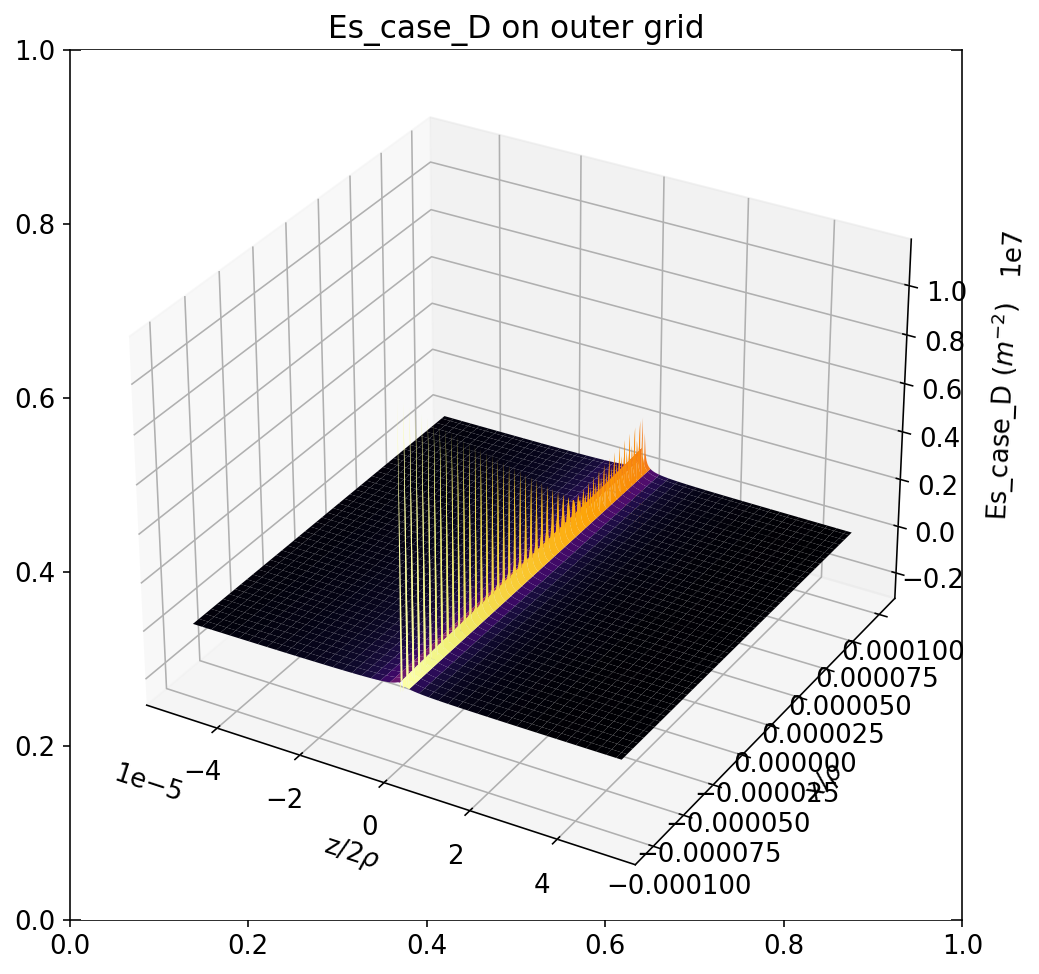

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(*meshes, Es_case_D_grid_IGF, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_D $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_D on outer grid')

In [8]:
def transient_calc_lambda_D_super_z(z_observe):
    return transient_calc_lambda_D(phi_m, lamb, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_D_grid_IGF)

In [9]:
x_observe = 0
transient_calc_lambda_D_super_z(0)

103931.59958079623

In [18]:
kaka = np.array(list(map(transient_calc_lambda_D_super_z,zvec)))

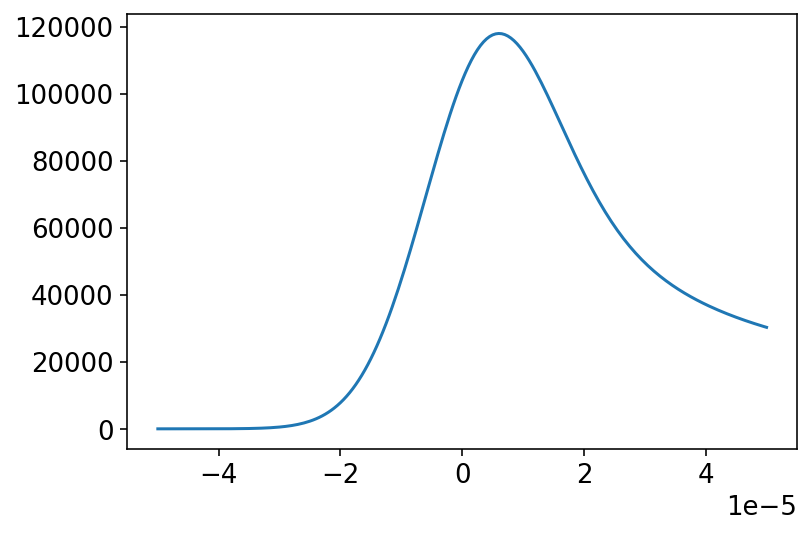

In [19]:
plt.plot( zvec, kaka )

# Super inner fine grid

In [7]:
from csr2d.core2 import Es_case_D, Es_case_B
from csr2d.wake import symmetric_vec

In [18]:
nz_small = 10001
dz_small = 5.0*10**(-13)
dzp_small = dz_small/(2*rho)
 
nx_small = 2001
dx_small = 5.0*10**(-8)
dxp_small = dx_small/(rho)
# Make an offset grid
vecs_small = [symmetric_vec(n, delta) for n, delta in zip([nz_small,nx_small], [dzp_small,dxp_small])] 
meshes_small = np.meshgrid(*vecs_small, indexing='ij')  # this gives zm2 and xm2

In [233]:
vecs_small[0][10000]

0.0

In [13]:
0.0002/1000

2.0000000000000002e-07

In [10]:
gamma = 5000
lamb = 0.1

In [19]:
Es_case_D_grid_small = Es_case_D(*meshes_small, gamma, lamb)

In [234]:
np.sum(Es_case_D_grid_small)

1897403479601637.5

In [241]:
np.sum(Es_case_D_grid_small[0:10000,:])

970214308474603.1

In [59]:
lala0 = Es_case_D(*meshes_small, gamma, 0)

In [61]:
Es_case_B_grid_small = Es_case_B(*meshes_small, gamma)

In [22]:
zvec_small = np.arange(-4*sigma_z, 4*sigma_z, dz_small)

In [19]:
zvec_small.shape

(160000001,)

In [23]:
#zvec_small = np.linspace(-5*sigma_z, 5*sigma_z, nz_small)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
Z_small, X_small = np.meshgrid(zvec_small, xvec, indexing='ij')
lambda_grid_filtered_small = lamb_2d(Z_small,X_small)

MemoryError: Unable to allocate 240. GiB for an array with shape (160000001, 201) and data type float64

In [21]:
lambda_grid_filtered_small.shape

(40001, 201)

In [13]:
zvec_small[1] - zvec_small[0]

2.4999999999987055e-09

In [29]:
lambda_grid_filtered_small.shape

(40001, 201)

In [30]:
Es_case_D_grid_small.shape

(80002, 402)

Text(0.5, 0.92, '$W_x$ benchmarking')

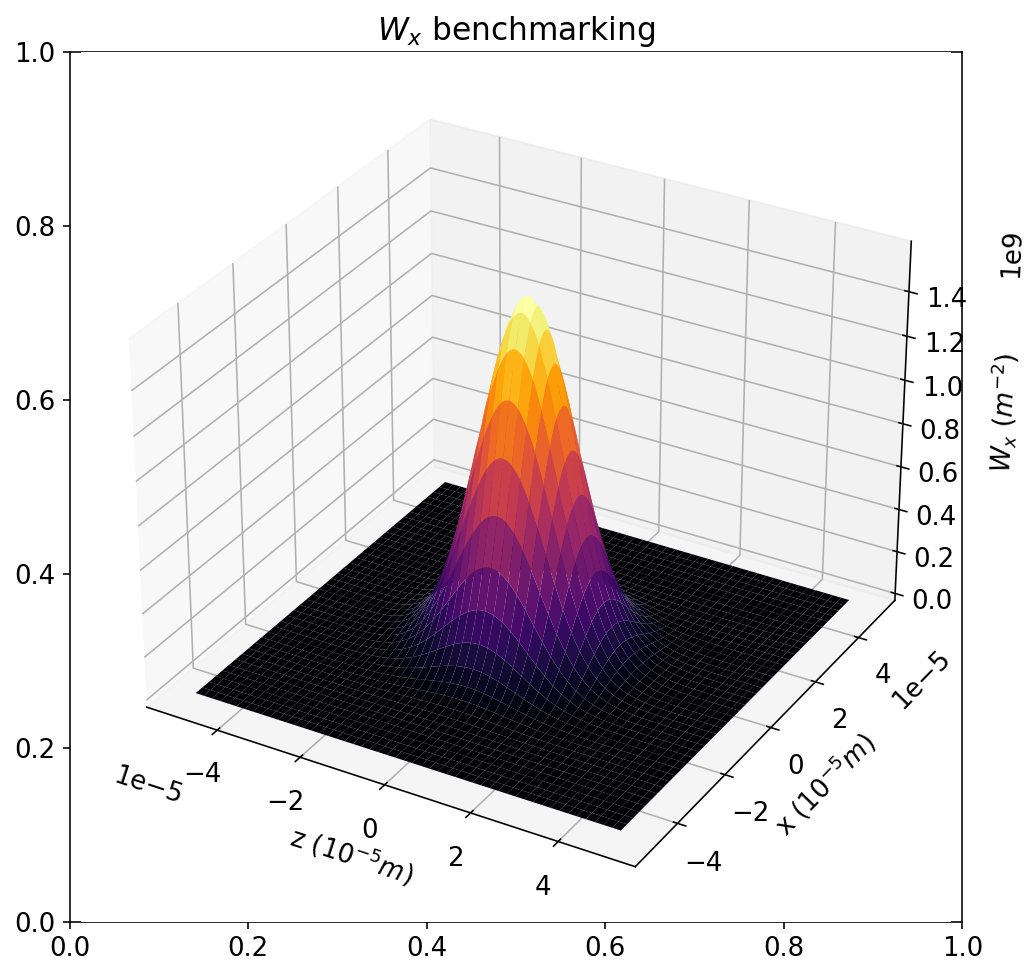

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z_small, X_small, lambda_grid_filtered_small, cmap='inferno', zorder=1)

ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

Text(0.5, 0.92, 'Es_case_D on inner fine grid')

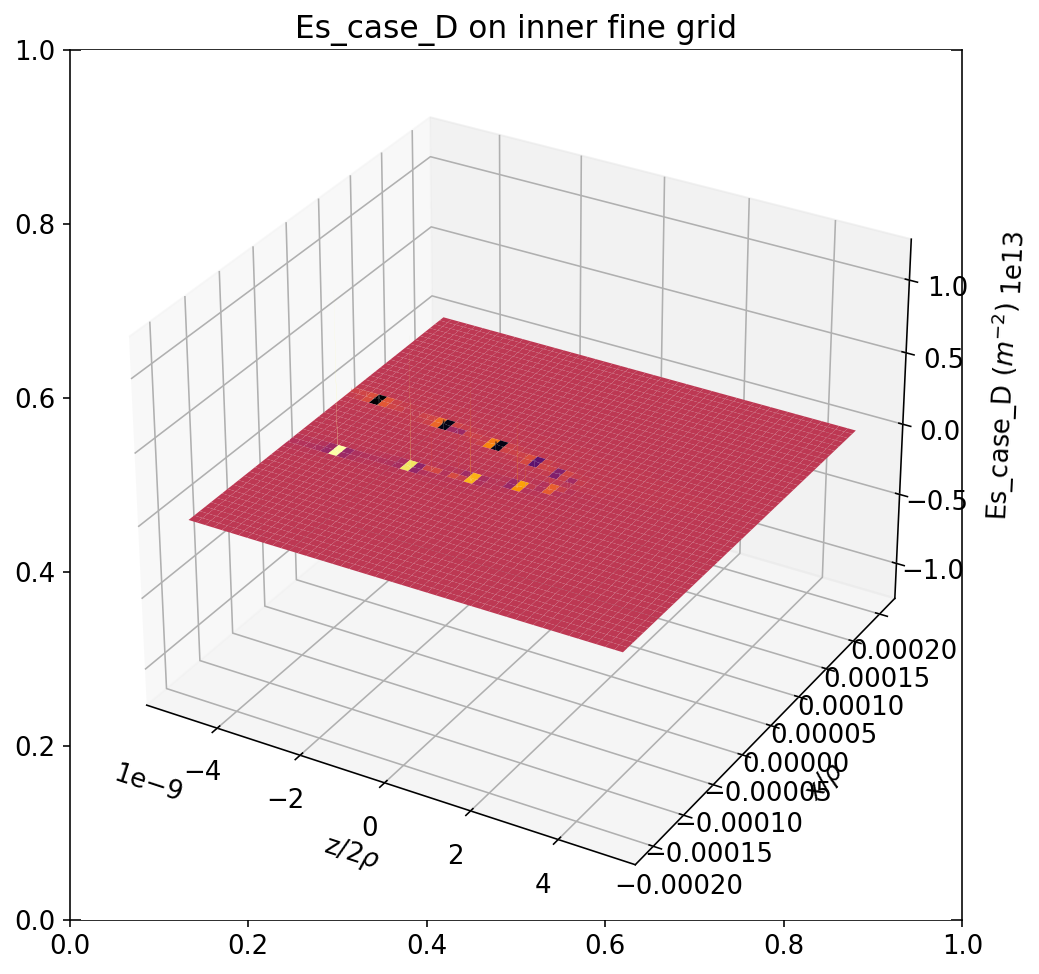

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(*meshes_small, Es_case_D_grid_small, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_D $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_D on inner fine grid')

In [21]:
np.sum(Es_case_D_grid_small)

1897403479601637.5

In [203]:

def z_singular_case_D(x):
    """
    Exact alpha calculation using numerical root finding.
    
    Eq. (23) from Ref[1]
    """
    
    def a(z):
        return alpha_exact_case_D(z, x, beta, lamb)
    
    def ap(z):
        NN = beta* ( (1+x)*np.sin(2*a(z)) + lamb*np.cos(2*a(z)) )
        #DD = np.sqrt( lamb**2 + x**2 + 4*(1+x)*np.sin(a(z))**2 + 2*lamb*np.sin(2*a(z)))
        DD = (2*(a(z) - z) + lamb)/beta
        
        return (1-NN/DD)**(-1)
   
    def f(z): # Denominator of Es_case D
        return (2*(a(z) - z) + lamb)/beta  - beta* ( lamb*np.cos(2*a(z)) + (1+x)*np.sin(2*a(z)))
    
    def fp(z):
        return (2/beta*(ap(z) - 1)) -  beta*( -lamb*np.sin(2*a(z)) + (1+x)*np.cos(2*a(z)))*2*ap(z)
    
    res = scipy.optimize.root_scalar(f, x0 = 0, fprime = fp, method='newton',xtol = 1e-15)
    

    return res.root

In [204]:
from numba import njit, vectorize, float64
from quantecon.optimize.root_finding import brentq, newton 
@njit
def a(z,x):
    return alpha_exact_case_D_brentq(z, x, beta, lamb)


@njit
def ap(z,x):
    NN = beta* ( (1+x)*np.sin(2*a(z,x)) + lamb*np.cos(2*a(z,x)) )
        #DD = np.sqrt( lamb**2 + x**2 + 4*(1+x)*np.sin(a(z))**2 + 2*lamb*np.sin(2*a(z)))
    DD = (2*(a(z,x) - z) + lamb)/beta
    return (1-NN/DD)**(-1)


@njit
def f(z,x): # Denominator of Es_case D
    return (2*(a(z,x) - z) + lamb)/beta  - beta* ( lamb*np.cos(2*a(z,x)) + (1+x)*np.sin(2*a(z,x)))

@njit
def fp(z,x):
    return (2/beta*(ap(z,x) - 1)) -  beta*( -lamb*np.sin(2*a(z,x)) + (1+x)*np.cos(2*a(z,x)))*2*ap(z,x)

@vectorize([float64(float64)])
def z_singular_case_D2(x):
    return newton(f, 0, fp, tol = 1e-10, args=(x,))[0]

In [226]:
#zsing_vec = np.array( list(map(z_singular_case_D,xvec)))
zsing_vec2 = z_singular_case_D2(xvec/2.5)

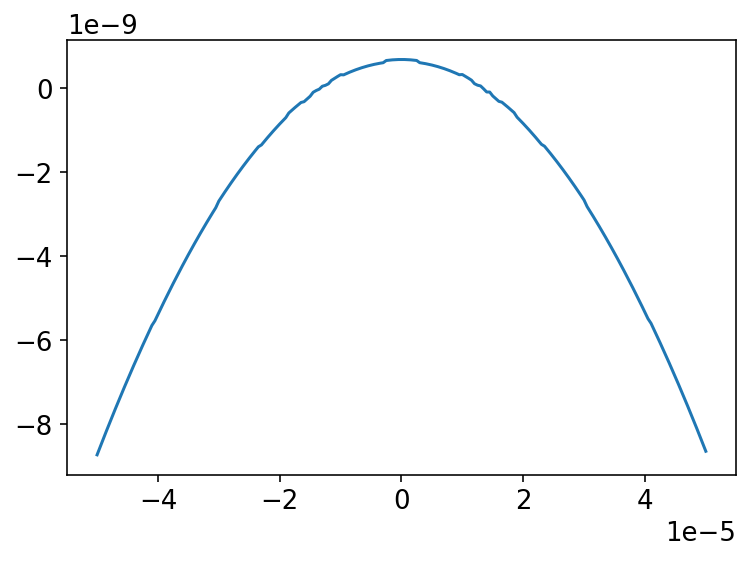

In [209]:
plt.plot(xvec, zsing_vec2 )

In [210]:
rho

1.0

In [238]:
temp = (0.0000 - xvec)/1.5

#zid_vec = rho*(phi_m + lamb - beta*np.sqrt(lamb**2 + temp**2 + 4*(1+temp)*np.sin(phi_m/2)**2 + 2*lamb*np.sin(phi_m)))
zod_vec = rho*(lamb - beta*np.sqrt(lamb**2 + temp**2))

In [239]:
rho

1.0

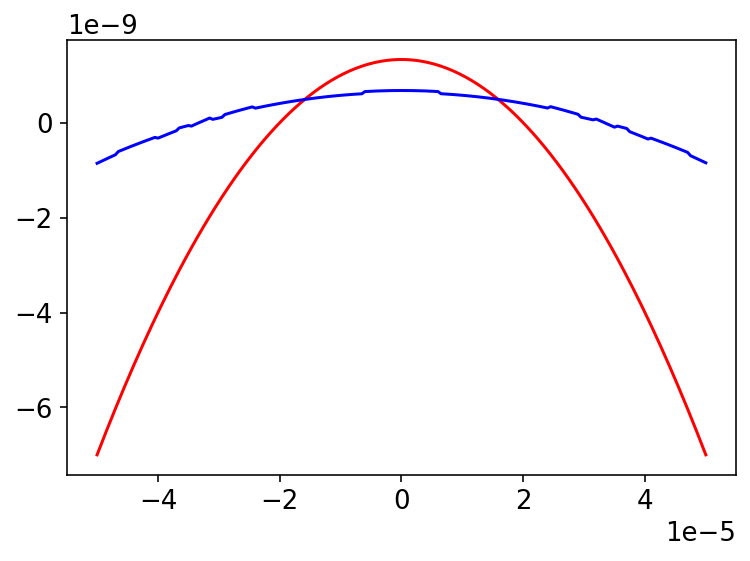

In [240]:
plt.plot(xvec, zod_vec, c='red')
plt.plot(xvec, zsing_vec2, c='blue' )

Text(0.5, 0.92, 'Es_case_D on inner fine grid')

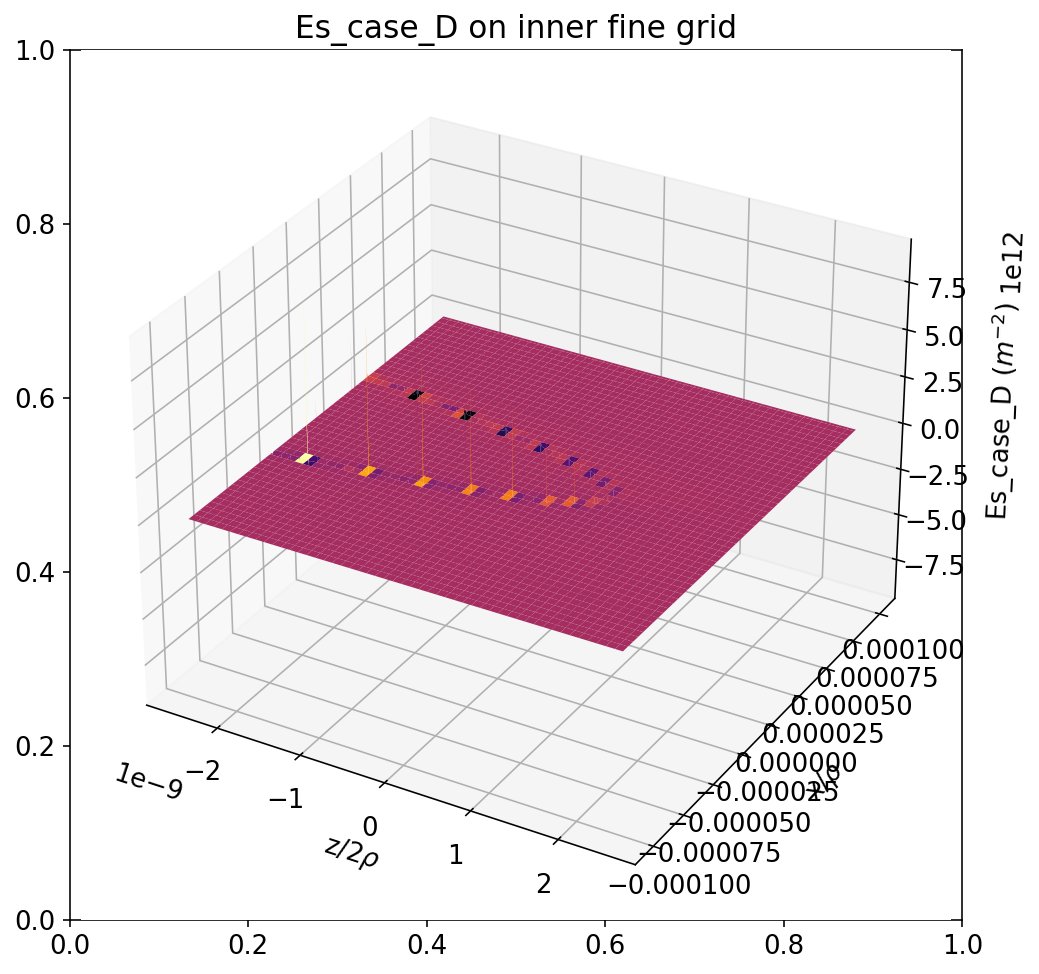

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(*meshes_small, Es_case_D_grid_small, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_D $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_D on inner fine grid')

Text(0.5, 0.92, 'Es_case_D on inner fine grid')

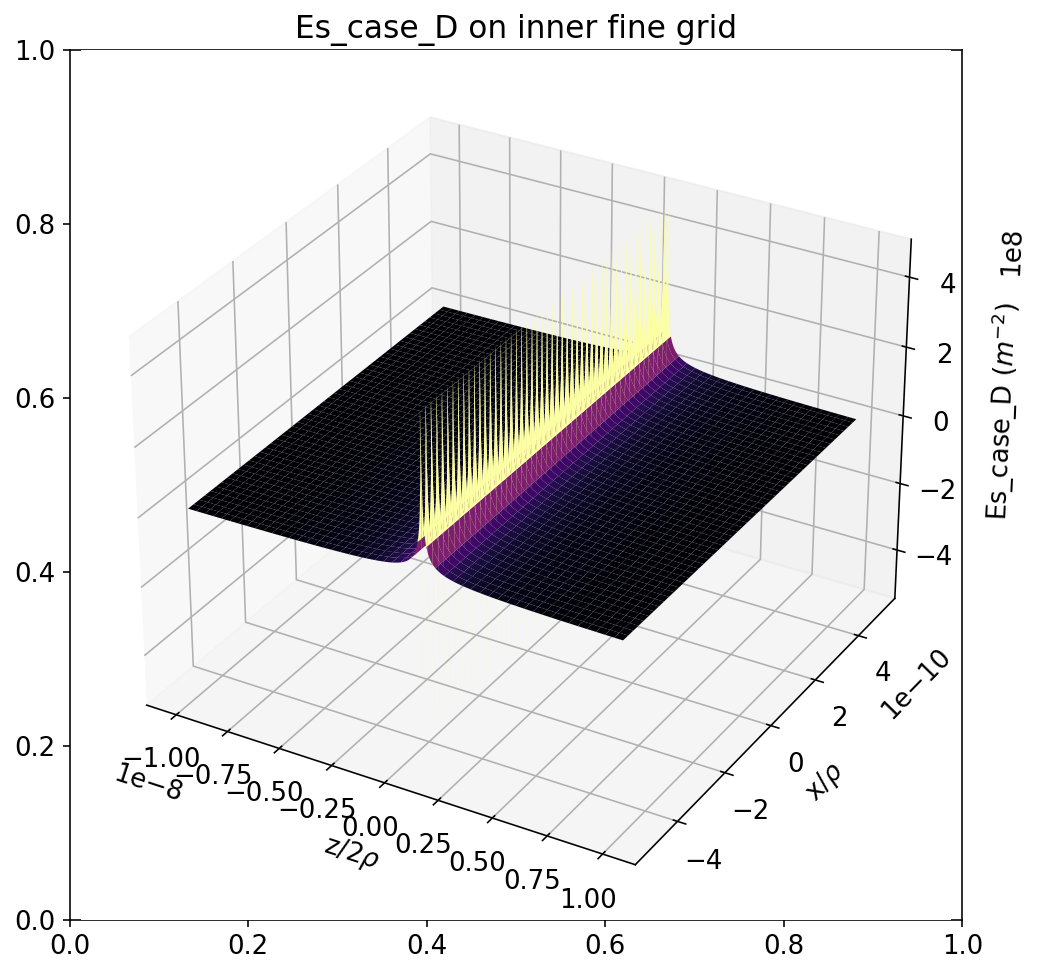

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(*meshes_small, Es_case_D_grid_small, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_D $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_D on inner fine grid')

Text(0.5, 0.92, 'Es_case_D on inner fine grid')

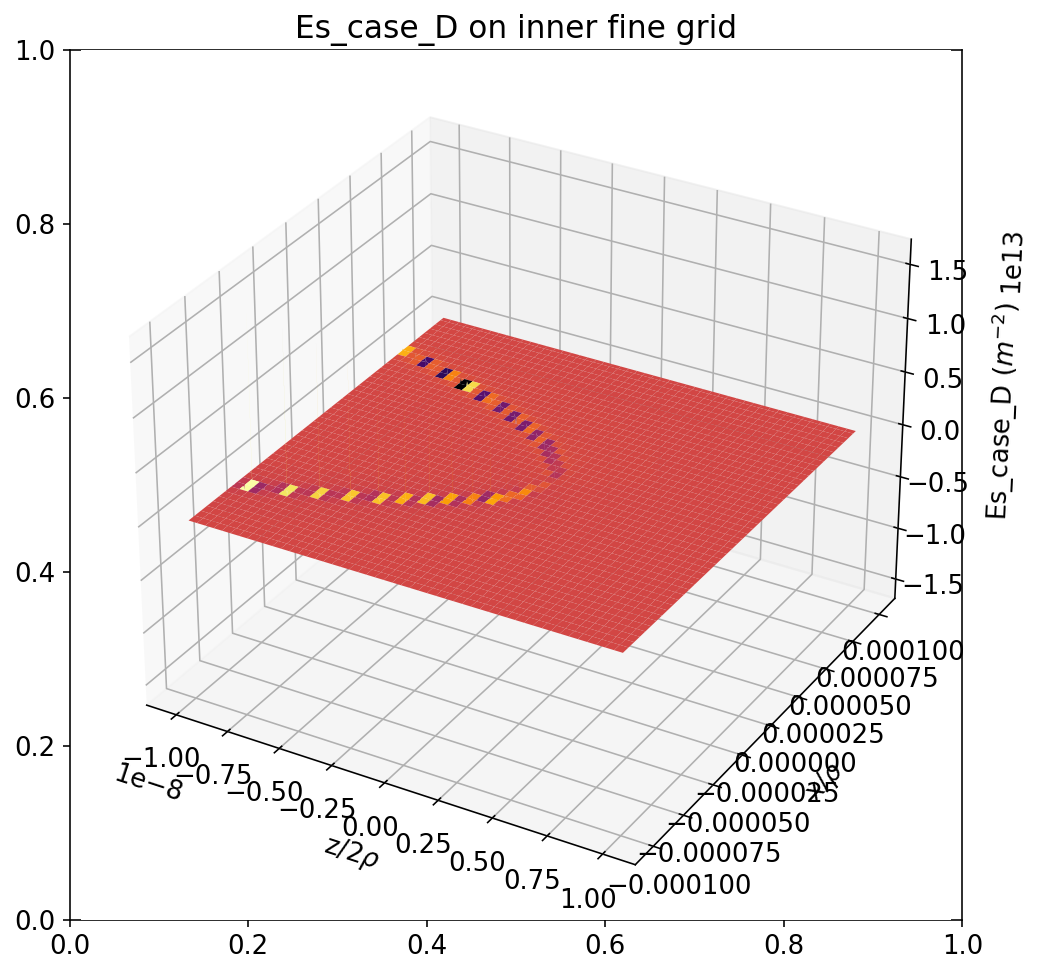

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(*meshes_small, Es_case_D_grid_small, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_D $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_D on inner fine grid')

In [100]:
zzz = meshes_small[0][5000:10000,1900:2056]
xxx = meshes_small[0][5000:10000,1900:2056]
Es_B_zzzxxx = Es_case_B_grid_small[5000:10000,1900:2056]
Es_D_zzzxxx = Es_case_D_grid_small[5000:10000,1900:2056]

In [90]:
zzz.shape

(20002, 156)

Text(0.5, 0.92, 'Es_case_B on inner fine grid')

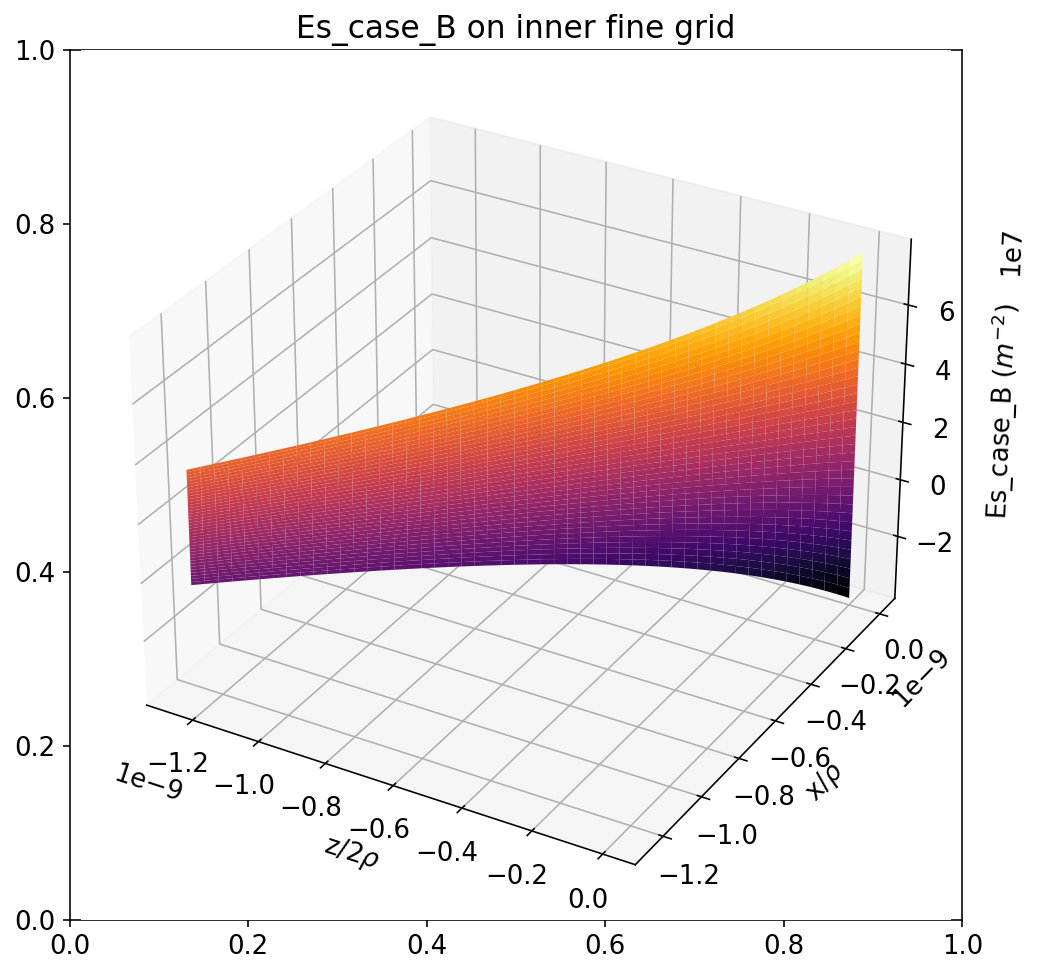

In [101]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface( zzz,xxx, Es_D_zzzxxx, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_B $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_B on inner fine grid')

Text(0.5, 0.92, 'Es_case_B on inner fine grid')

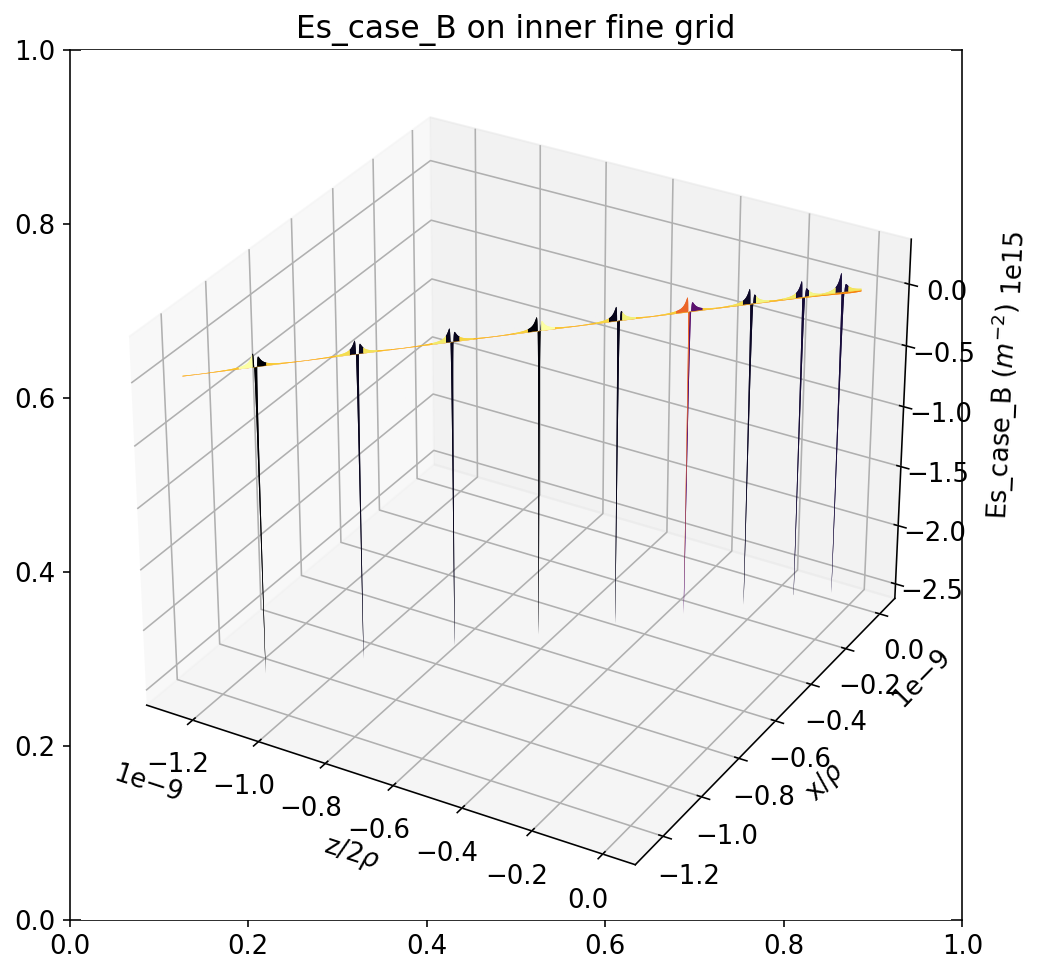

In [99]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface( zzz,xxx, Es_B_zzzxxx, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_B $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_B on inner fine grid')

Text(0.5, 0.92, 'Es_case_B on inner fine grid')

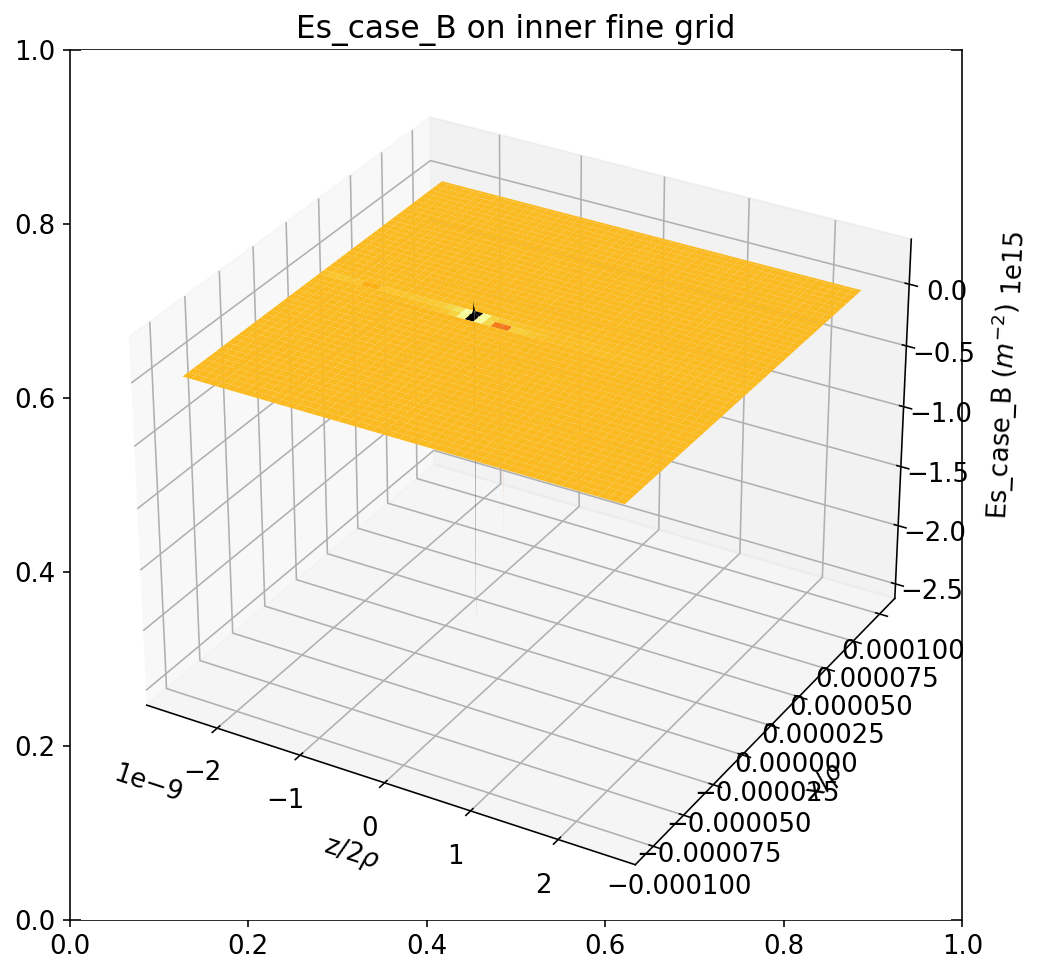

In [64]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(*meshes_small, Es_case_B_grid_small, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_B $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_B on inner fine grid')

In [39]:
Es_case_D_grid_small.shape

(20002, 4002)

In [37]:
nx_small

2001

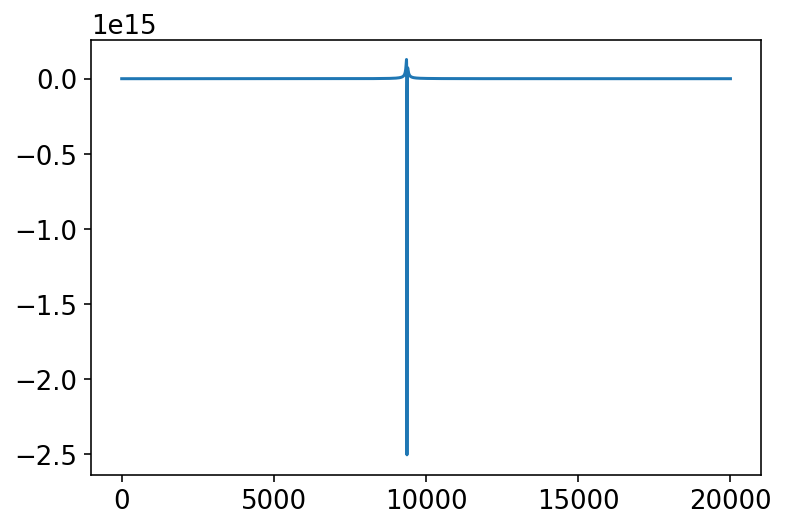

In [97]:
plt.plot(Es_case_B_grid_small[:,2010])

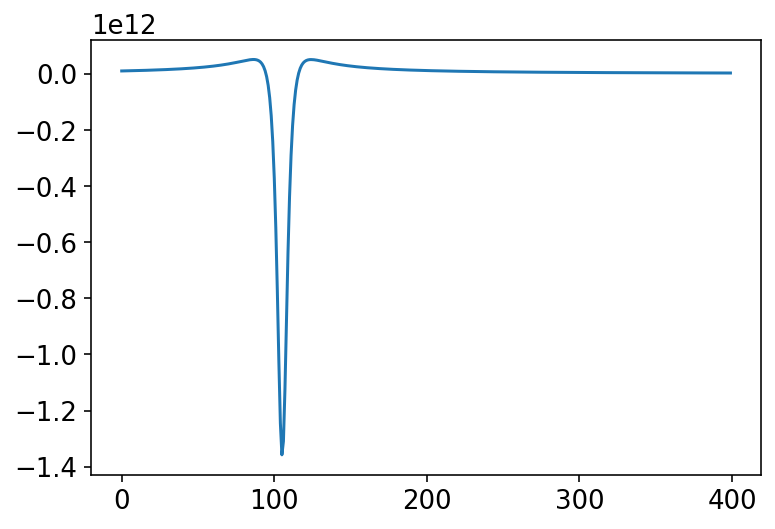

In [51]:
plt.plot(Es_case_D_grid_small[13600:14000,2109])

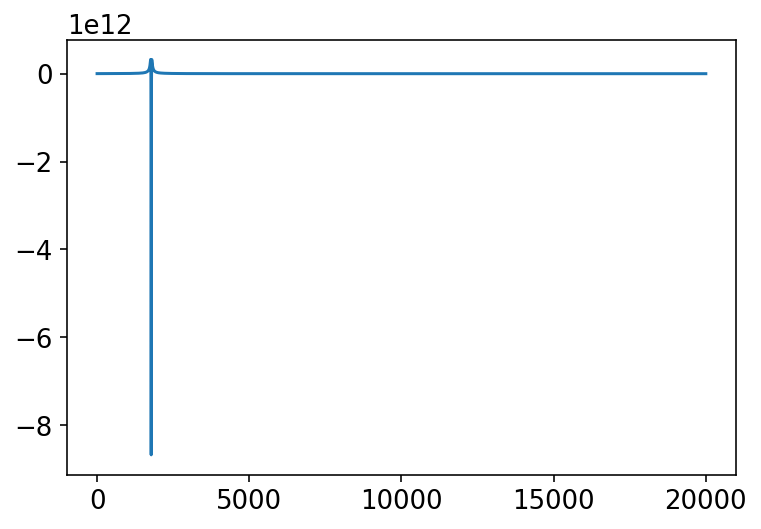

In [60]:
plt.plot(Es_case_D_grid_small[:,2700])

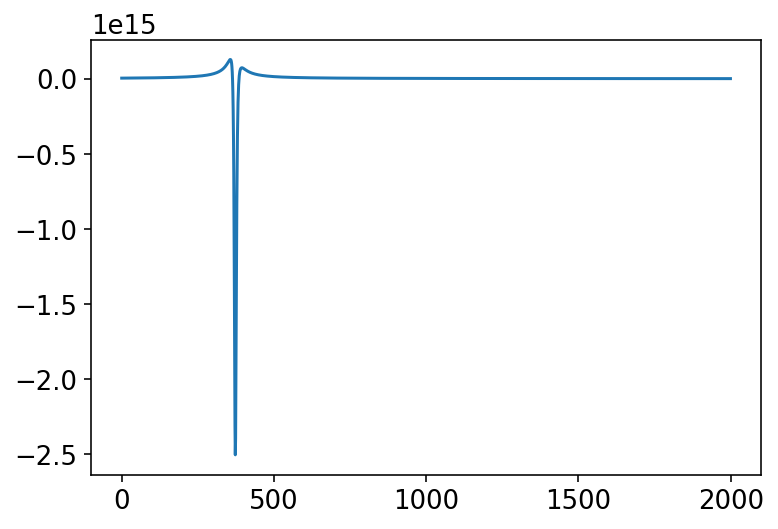

In [52]:
plt.plot(Es_case_B_grid_small[39000:41000,201])

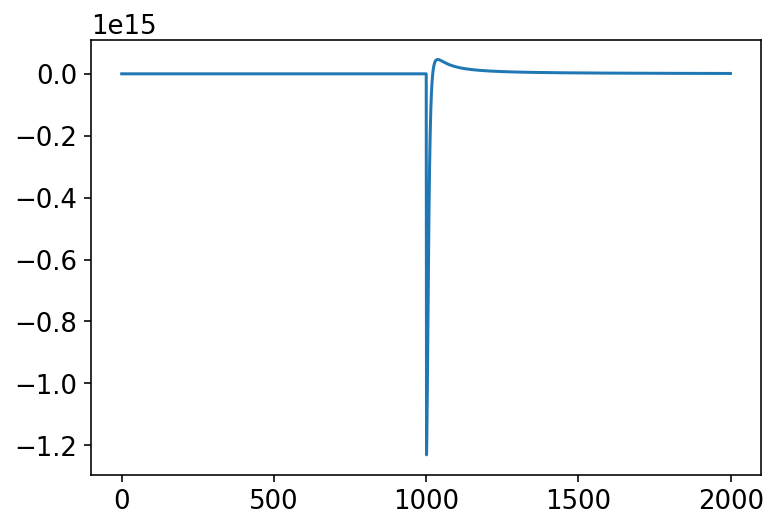

In [43]:
plt.plot(Es_case_B_grid_small[39000:41000,200])

In [110]:
lamb

0.1

# Checking boundary line

In [166]:
phi_m = 0.5/rho
lamb = 0.001

x_observe = 0.000
z_observe = 0
# Boundary condition 
temp = (x_observe - xvec)/rho
#zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
#zo_vec = -beta*np.abs(x_observe - xvec)

zid_vec = rho*(phi_m + lamb - beta*np.sqrt(lamb**2 + temp**2 + 4*(1+temp)*np.sin(phi_m/2)**2 + 2*lamb*np.sin(phi_m)))
zod_vec = rho*(lamb - beta*np.sqrt(lamb**2 + temp**2))

nz = len(zvec)
nx = len(xvec)

# Allocate array for histogrammed data
cond = np.zeros( (nz,nx) )

for i in range(nx):
    cond[:,i]  = (zvec > z_observe - zod_vec[i]) | (zvec < z_observe - zid_vec[i])


lambda_grid_filtered_bounded = np.where(cond, 0, lambda_grid_filtered)

Text(0.5, 0.92, 'Es_case_B on inner fine grid')

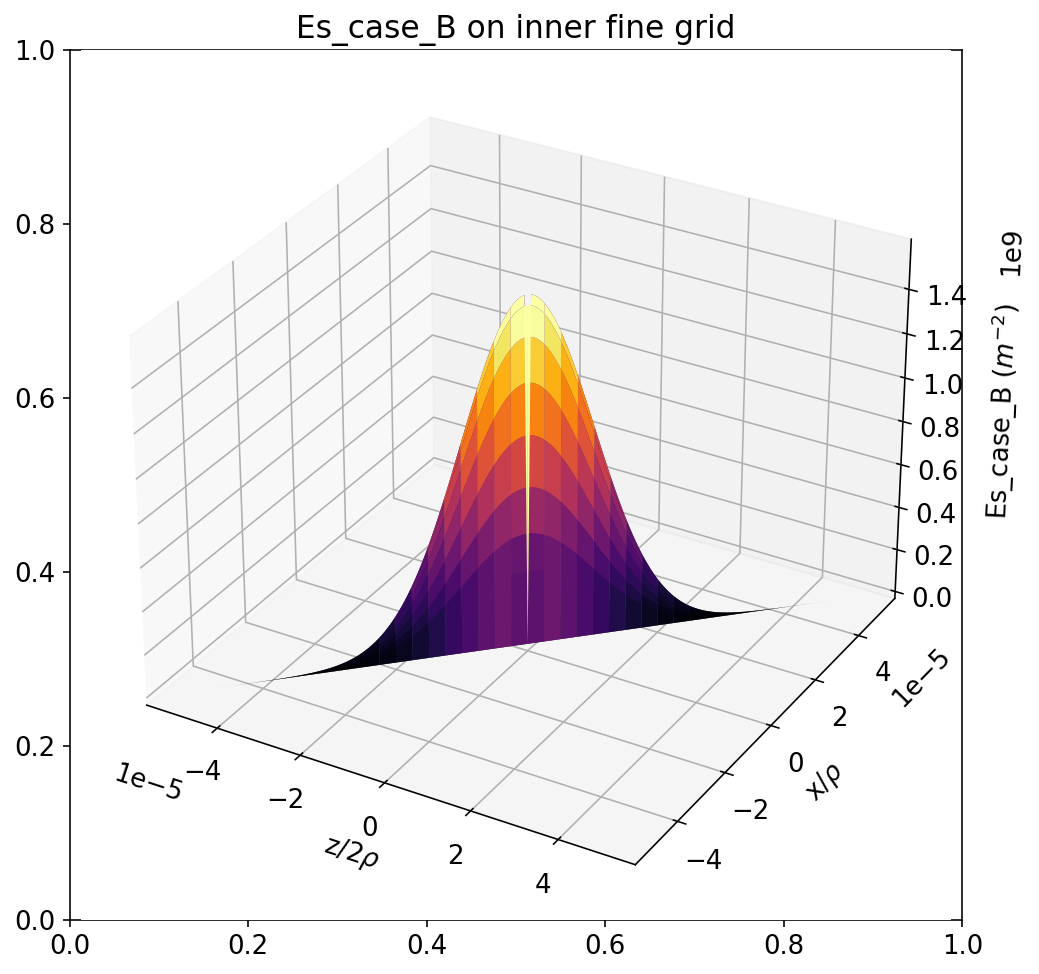

In [167]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zvec,xvec, lambda_grid_filtered_bounded, cmap='inferno', zorder=1)

ax.set_xlabel(r'z/$2\rho$')
ax.set_ylabel(r'x/$\rho$')
ax.set_zlabel(r'Es_case_B $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'Es_case_B on inner fine grid')

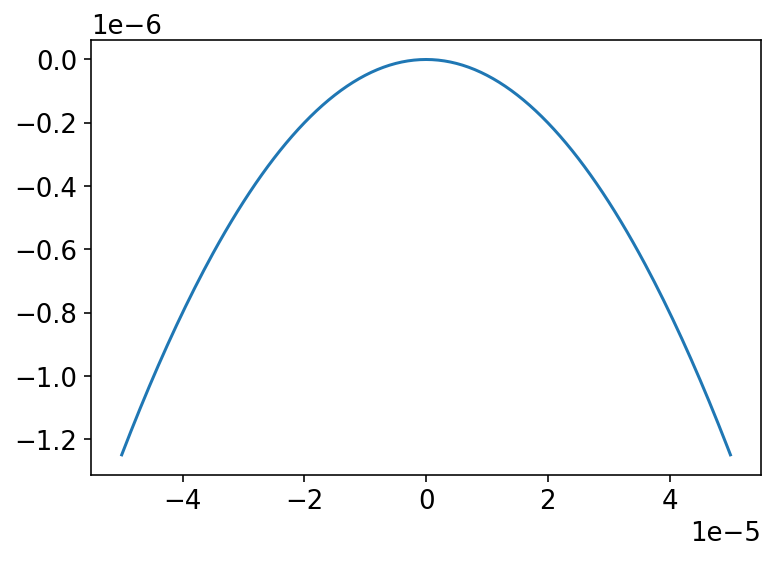

In [168]:
plt.plot(xvec,zod_vec)

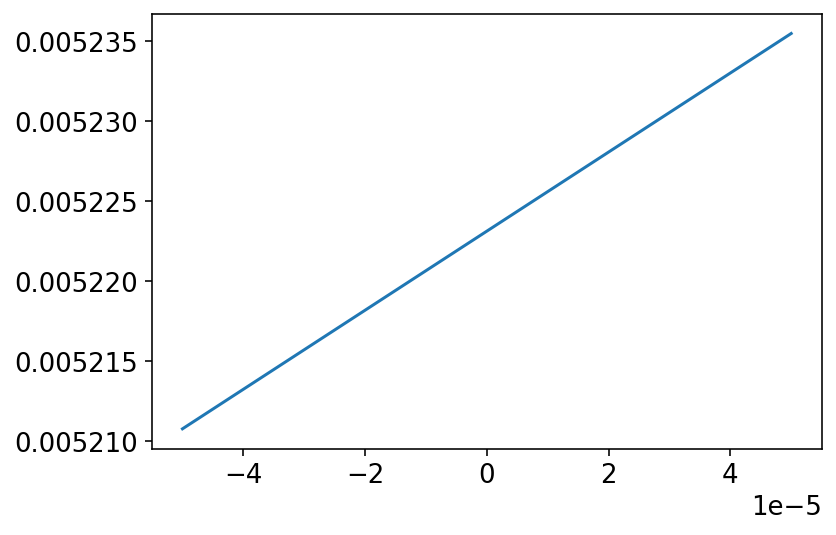

In [169]:
plt.plot(xvec,zid_vec)

In [186]:
lamb = 0.1/1.5

In [177]:
from csr2d.core2 import alpha_exact_case_D_brentq, alpha_exact_case_D

In [181]:
zt = 1e-3
xt = 1e-3
alpha_exact_case_D(zt, xt, beta, lamb)

array(0.15421394)

In [187]:
alpha_exact_case_D_brentq(zt, xt, beta, lamb)

0.1618793974691195

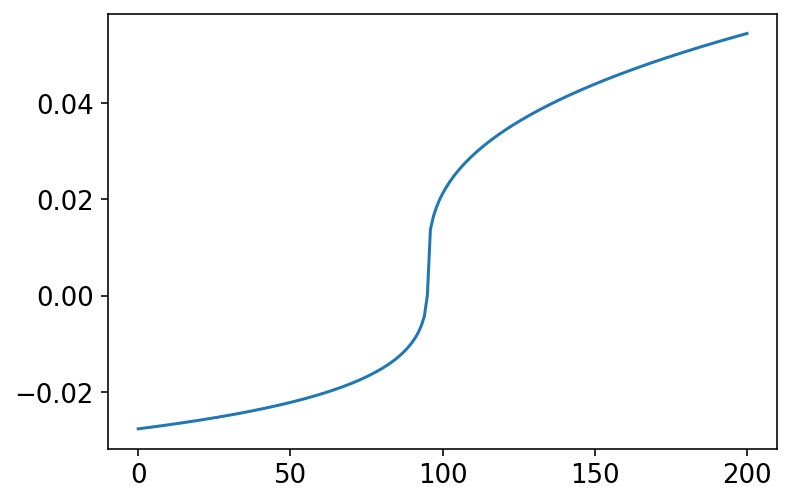

In [184]:
plt.plot(alpha_exact_case_D_brentq(zvec, xt, beta, lamb))

In [191]:
Es_case_D(1E-9, 1E-3, gamma, lamb)*beta**2/1.5**2

282738.9830725676

In [193]:
Es_case_D(1E-9, 1E-9, gamma, lamb)*beta**2/1.5**2

75882649.78965187

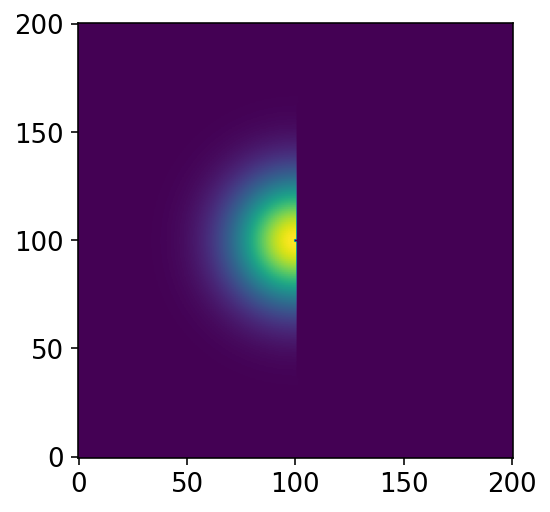

In [170]:
plt.imshow(lambda_grid_filtered_bounded.T, origin='lower')

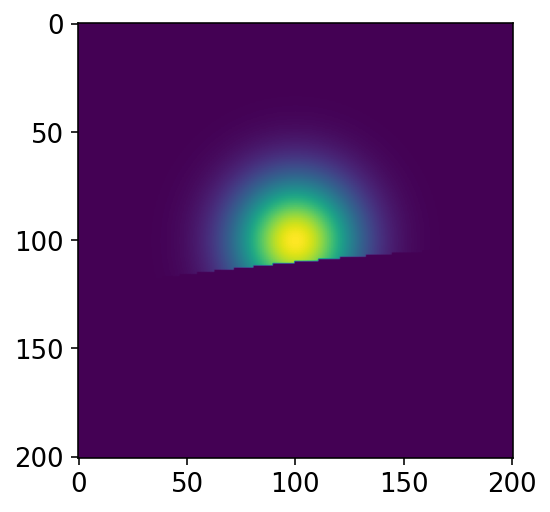

In [164]:
plt.imshow(lambda_grid_filtered_bounded)

In [ ]:
g =5 

In [60]:
@vectorize([float64(float64)])
def transient_calc_lambda_D_super_z_small(z_observe):
    return transient_calc_lambda_D(phi_m, lamb, z_observe, x_observe, zvec_small, xvec, dz_small, dx, lambda_grid_filtered_small, Es_case_D_grid_small)

In [66]:
x_observe = -0.0001
jaja = np.array(list(map(transient_calc_lambda_D_super_z_small,zvec)))

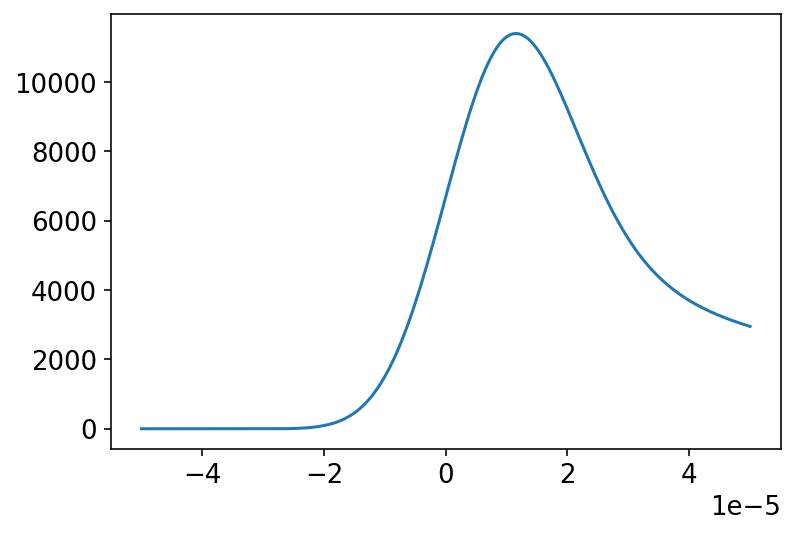

In [67]:
plt.plot( zvec, jaja )

In [102]:
kaka[90:110]

array([ 75664.34541291,  78837.58486469,  81969.99522588,  85047.70709071,
        88056.87417092,  90983.79892424,  93815.05911315,  96537.63353978,
        99139.02518427, 101607.3799892 , 103931.5995808 , 106101.4462994 ,
       108107.6390242 , 109941.93841976, 111597.22040033, 113067.53679981,
       114348.16244546, 115435.62805873, 116327.73864066, 117023.57723851])

In [101]:
jaja[90:110]

array([3626.73443057, 3900.03379148, 4182.86933587, 4474.51832952,
       4774.15640478, 5080.86019332, 5393.61127591, 5711.30145338,
       6032.73932086, 6356.65810466, 6681.72469861, 7006.54981412,
       7329.69913705, 7649.70536397, 7965.08097238, 8274.33156322,
       8575.96960082, 8868.52836465, 9150.57592068, 9420.72891597])

In [51]:
Es_case_D_grid_small.shape

(80002, 402)

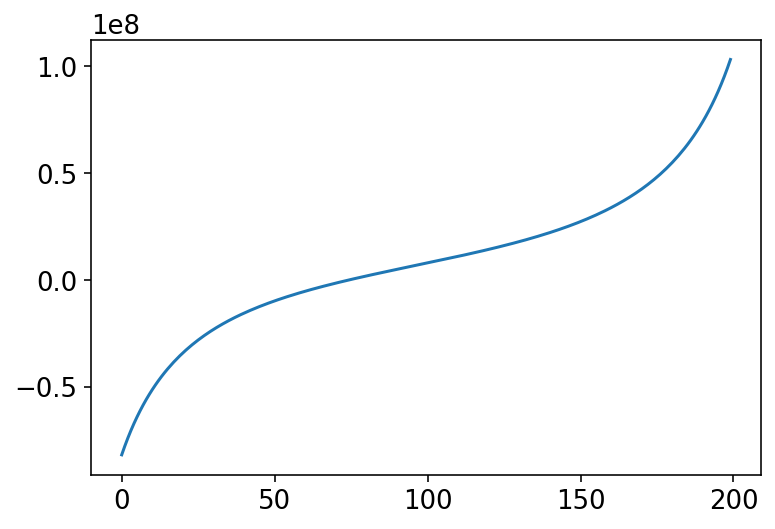

In [35]:
plt.plot(Es_case_D_grid_small[565,100:300])

In [1]:
plt.plot(Es_case_D_grid_small[39000:41000,200])

NameError: name 'plt' is not defined

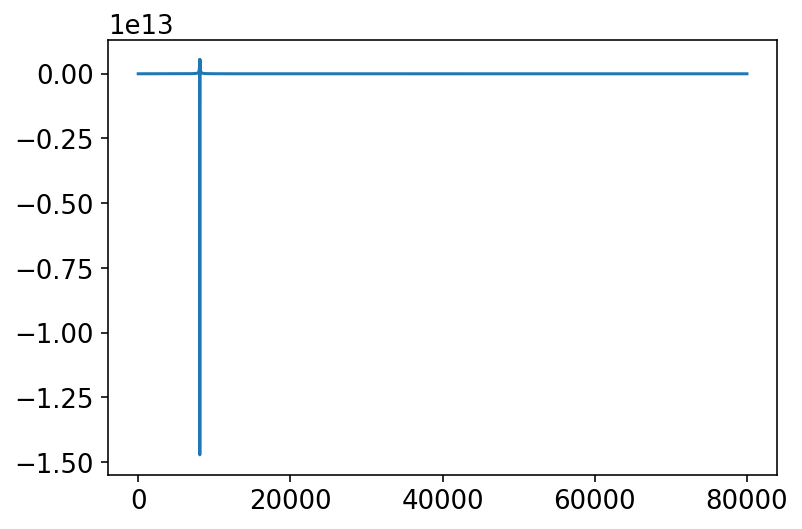

In [56]:
plt.plot(Es_case_D_grid_small[:,320])

In [57]:
np.sum(Es_case_D_grid_small)

552728701636084.3

In [58]:
np.sum(Es_case_B_grid_small)

-2.9774492584603324e+16

# Try cases with different sigma_x...
# Compare Sum(grid) with case B IGF
# change (x,z) to (x,alpha) ? lambda might be hard to normalize...? alpha is